In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("data/processed/loan_master_final.csv")

X = df.drop(columns=["default_flag"])
y = df["default_flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


In [3]:
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc = pd.get_dummies(X_test, drop_first=True)

# align columns
X_train_enc, X_test_enc = X_train_enc.align(
    X_test_enc, join="left", axis=1, fill_value=0
)


#XGBClassifier

In [4]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
)

xgb_model.fit(X_train_enc, y_train)

print("XGBoost training completed")


XGBoost training completed


In [5]:
xgb_pred = xgb_model.predict(X_test_enc)
xgb_prob = xgb_model.predict_proba(X_test_enc)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

print("XGBoost ROC-AUC:", roc_auc_score(y_test, xgb_prob))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     26999
           1       0.41      0.81      0.55      3001

    accuracy                           0.87     30000
   macro avg       0.69      0.84      0.73     30000
weighted avg       0.92      0.87      0.88     30000

XGBoost ROC-AUC: 0.9264752533382116


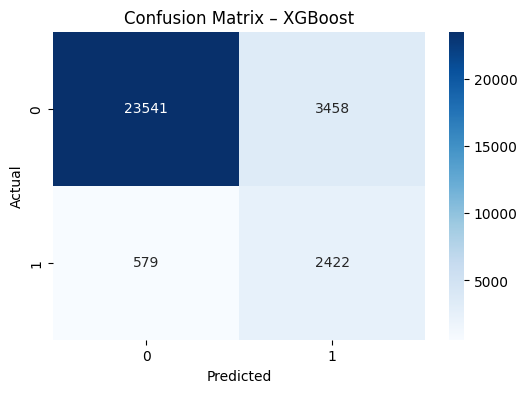

In [6]:
cm = confusion_matrix(y_test, xgb_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [7]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)

In [8]:
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("Precision:", precision_score(y_test, xgb_pred))
print("Recall:", recall_score(y_test, xgb_pred))
print("F1 Score:", f1_score(y_test, xgb_pred))

Accuracy: 0.8654333333333334
Precision: 0.4119047619047619
Recall: 0.8070643118960347
F1 Score: 0.5454340727395564


In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


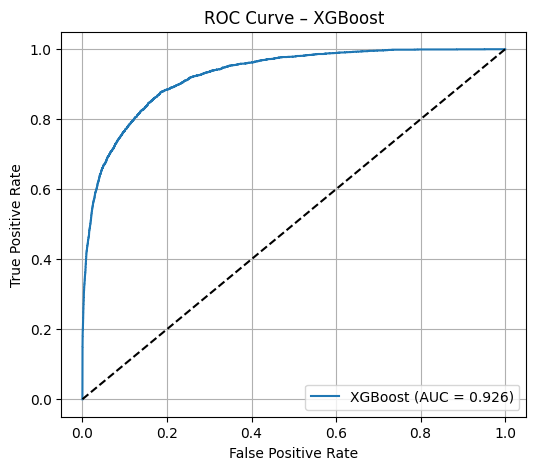

In [10]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_prob)
auc_xgb = roc_auc_score(y_test, xgb_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#LGBMClassifier

In [11]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)

lgb_model.fit(X_train_enc, y_train)

print("LightGBM training completed")


[LightGBM] [Info] Number of positive: 7003, number of negative: 62997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM training completed


In [12]:
lgb_pred = lgb_model.predict(X_test_enc)
lgb_prob = lgb_model.predict_proba(X_test_enc)[:, 1]

print("LightGBM Classification Report:")
print(classification_report(y_test, lgb_pred))

print("LightGBM ROC-AUC:", roc_auc_score(y_test, lgb_prob))


LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     26999
           1       0.42      0.81      0.55      3001

    accuracy                           0.87     30000
   macro avg       0.70      0.84      0.74     30000
weighted avg       0.92      0.87      0.88     30000

LightGBM ROC-AUC: 0.9278295928099033


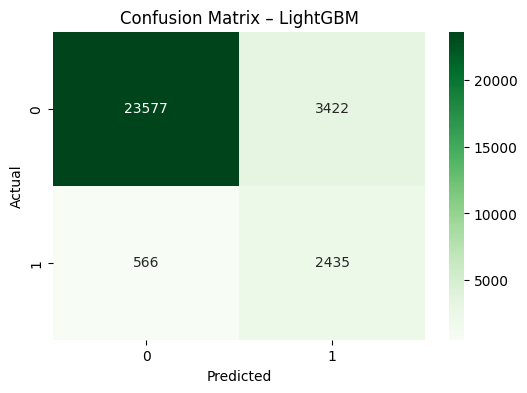

In [13]:
cm = confusion_matrix(y_test, lgb_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix – LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [14]:
print("Accuracy:", accuracy_score(y_test, lgb_pred))
print("Precision:", precision_score(y_test, lgb_pred))
print("Recall:", recall_score(y_test, lgb_pred))
print("F1 Score:", f1_score(y_test, lgb_pred))

Accuracy: 0.8670666666666667
Precision: 0.41574184736213077
Recall: 0.8113962012662446
F1 Score: 0.5497855046285843


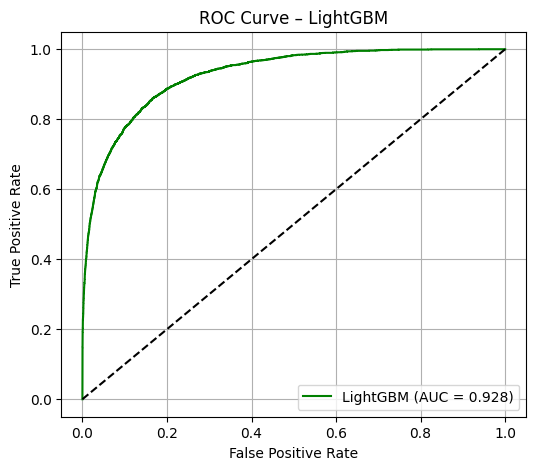

In [15]:
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_prob)
auc_lgb = roc_auc_score(y_test, lgb_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr_lgb, tpr_lgb, label=f"LightGBM (AUC = {auc_lgb:.3f})", color="green")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – LightGBM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


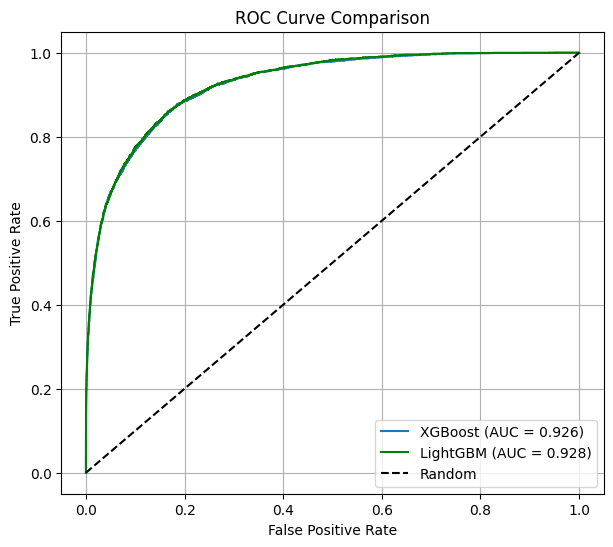

In [16]:
plt.figure(figsize=(7,6))

plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot(fpr_lgb, tpr_lgb, label=f"LightGBM (AUC = {auc_lgb:.3f})", color="green")
plt.plot([0,1], [0,1], 'k--', label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [18]:
import joblib
import os

joblib.dump(
    xgb_model,
    "models/xgboost_model.pkl"
)

print("✅ XGBoost model saved")
joblib.dump(
    lgb_model,
    "models/lightgbm_model.pkl"
)

✅ XGBoost model saved


['models/lightgbm_model.pkl']

In [19]:
feature_columns = X_train_enc.columns.tolist()

joblib.dump(
    feature_columns,
    "models/feature_columns.pkl"
)

print("✅ Feature columns saved")


✅ Feature columns saved


In [20]:
model_metadata_all = {
    "final_model": "LightGBM",
    "baseline_auc": 0.915,
    "xgboost_auc": 0.926,
    "lightgbm_auc": 0.928,
    "dataset": "loan_master_final.csv",
    "target": "default_flag",
    "note": "Threshold can be tuned based on business need"
}

joblib.dump(
    model_metadata_all,
    "models/model_metadata_all.pkl"
)

print("✅ Model metadata saved")


✅ Model metadata saved


In [21]:
loaded_model = joblib.load("models/lightgbm_model.pkl")
loaded_features = joblib.load("models/feature_columns.pkl")

print("Model loaded:", type(loaded_model))
print("Feature count:", len(loaded_features))


Model loaded: <class 'lightgbm.sklearn.LGBMClassifier'>
Feature count: 91


In [22]:
def predict_default(input_df, model, feature_cols):
    input_df = pd.get_dummies(input_df)

    # align columns
    input_df = input_df.reindex(columns=feature_cols, fill_value=0)

    prob = model.predict_proba(input_df)[0][1]
    pred = int(prob >= 0.5)

    return {
        "probability_default": prob,
        "prediction": pred
    }
